## Golf Club Detector (cole henry MAR-2023)
### train a new keypoint model for Detectron2 to recognize club knob/tip

### Run this cell to mount your Google drive

In [1]:
import os, shutil, sys
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os, shutil, sys
# Configs
EPOCHS = 10
BATCH_SIZE = 2
# bat or golf. pick a club.
#club = 'bat'    
club = 'golf'

datafolder = f'/content/drive/MyDrive/{club}train'
os.makedirs(datafolder, exist_ok=True)
  
datafolder = datafolder + '/data/'
os.makedirs(datafolder, exist_ok=True)

print("Working directory:" , os.getcwd())
print("Image data directory:", datafolder)


Working directory: /content
Image data directory: /content/drive/MyDrive/golftrain/data/


In [3]:
!pip install tqdm
!pip install wget
#!pip install Detectron2
!pip install git+https://github.com/facebookresearch/detectron2
!pip install funcy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=9df27131ee3623755932fbcff449c28a17edcb49b5a924e629b132ce6b5a7c64
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2 to /tmp/pip-req-build-jqaf1cp1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2 /tmp/pip-req-build-jqaf1cp1
  Resolved https://github.com/facebookresearch/detectron2 to commit d779ea63faa54fe42b9b4c280365eaafccb280d6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import argparse
import funcy
from sklearn.model_selection import train_test_split

### Count the JPG files. Count the TXT files.

In [4]:
import fnmatch
jpgcount = len(fnmatch.filter(os.listdir(datafolder), '*.jpg'))
print("Data folder contains", jpgcount, "JPG files.")
txtcount = len(fnmatch.filter(os.listdir(datafolder), '*.text'))
print("Data folder contains", txtcount, "TEXT files.")
jsoncount = len(fnmatch.filter(os.listdir(datafolder), '*.text'))
print("Data folder contains", jsoncount, "JSON files.")

Data folder contains 209 JPG files.
Data folder contains 1 TEXT files.
Data folder contains 1 JSON files.


### RUN THIS (ONLY) IF YOU WANT TO CLEAR OUT THE DATA FOLDER! DELETES ALL FILES

In [ ]:
for filename in os.listdir(datafolder):
    file_path = os.path.join(datafolder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

### Pull a new labels.json file. 

In [ ]:
import wget
import os

gdrive_json = f"{datafolder}labels.json"
if os.path.isfile(gdrive_json):
  os.remove(gdrive_json)
url = f'https://www.powerchalk.com/streams/{club}train/labels.json'
wget.download(url,out = datafolder)

'/content/drive/MyDrive/golftrain/data//labels.json'

### get the zip of all data from an internet source and extract to mounted data folder

In [ ]:
from tqdm import tqdm
import wget
import os
import zipfile

data_url = f'https://www.powerchalk.com/streams/{club}train/{club}train.zip'
data_file = wget.download(data_url)
print(f'Data file: {data_file}')

with zipfile.ZipFile(data_file, 'r') as zip_ref:
    zip_ref.extractall(f'{datafolder}')

Data file: golftrain.zip


#### Train/Test splitter
##### Annotations are in a single file: `labels.json` This leaves the JPGs in place but creates a test and train json file to accomplish splitting.

In [5]:
annotationsFile = f'{datafolder}labels.json'
trainAnnoFile = f'{datafolder}train.json'
testAnnoFile = f'{datafolder}test.json'
splitPercent = 0.9
mustHaveAnno = True

def save_coco(file, info, licenses, images, annotations, categories):
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump({ 'info': info, 'licenses': licenses, 'images': images, 
            'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = funcy.lmap(lambda i: int(i['id']), images)
    return funcy.lfilter(lambda a: int(a['image_id']) in image_ids, annotations)


with open(annotationsFile, 'rt', encoding='UTF-8') as annotations:
    coco = json.load(annotations)
    info = coco['info']
    licenses = coco['licenses']
    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']
    number_of_images = len(images)
    images_with_annotations = funcy.lmap(lambda a: int(a['image_id']), annotations)

    if mustHaveAnno:
        images = funcy.lremove(lambda i: i['id'] not in images_with_annotations, images)

    x, y = train_test_split(images, train_size=splitPercent, random_state=42)

    save_coco(trainAnnoFile, info, licenses, x, filter_annotations(annotations, x), categories)
    save_coco(testAnnoFile, info, licenses, y, filter_annotations(annotations, y), categories)

    print("Saved {} entries in {}".format(len(x), trainAnnoFile))
    print("Saved {} entries in {}".format(len(y), testAnnoFile))


Saved 188 entries in /content/drive/MyDrive/golftrain/data/train.json
Saved 21 entries in /content/drive/MyDrive/golftrain/data/test.json


In [6]:
import numpy as np
import matplotlib.pyplot as plt
# import some common libraries
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger

from detectron2.data import (MetadataCatalog,
                             build_detection_train_loader,
                             build_detection_test_loader,
                             DatasetMapper, transforms as T,
                             detection_utils as utils)
setup_logger()

<Logger detectron2 (DEBUG)>

#### Register the new keypoint model

In [7]:
from detectron2.data.datasets import register_coco_instances
#DatasetCatalog.clear()
if f'{club}_train' in DatasetCatalog.list():
    DatasetCatalog.remove(f'{club}_train')
    
register_coco_instances(f"{club}_train", {}, f"{datafolder}train.json", datafolder)
register_coco_instances(f"{club}_test", {}, f"{datafolder}test.json", datafolder)

keypoint_names = ['knob', 'tip']
keypoint_flip_map = [('knob', 'tip')]

from detectron2.data import MetadataCatalog
classes = MetadataCatalog.get(f"{club}_train").thing_classes = ["st_bat"]
print(classes)

MetadataCatalog.get(f"{club}_train").thing_classes = ["st_bat"]
MetadataCatalog.get(f"{club}_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get(f"{club}_train").keypoint_names = keypoint_names
MetadataCatalog.get(f"{club}_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get(f"{club}_train").evaluator_type="coco"

['st_bat']


### Verify new keypoints by viewing annotation.

[03/31 11:26:20 d2.data.datasets.coco]: Loaded 188 images in COCO format from /content/drive/MyDrive/golftrain/data/train.json
D: {'file_name': '/content/drive/MyDrive/golftrain/data/110_53292190-DE8D-EB91-521C-FF44D4E33C02_0050.jpg', 'height': 720, 'width': 1280, 'image_id': 1049, 'annotations': [{'iscrowd': 0, 'bbox': [669, 384, 38, 265], 'keypoints': [697.5, 394.5, 2, 679.5, 639.5, 2], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
Showing /content/drive/MyDrive/golftrain/data/110_53292190-DE8D-EB91-521C-FF44D4E33C02_0050.jpg
D: {'file_name': '/content/drive/MyDrive/golftrain/data/110_53292190-DE8D-EB91-521C-FF44D4E33C02_0022.jpg', 'height': 720, 'width': 1280, 'image_id': 1021, 'annotations': [{'iscrowd': 0, 'bbox': [667, 374, 38, 243], 'keypoints': [695.5, 384.5, 2, 677.5, 607.5, 2], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
Showing /content/drive/MyDrive/golftrain/data/110_53292190-DE8D-EB91-521C-FF44D4E33C02_0022.jpg
D: {'file_name': '/content/drive/MyDriv

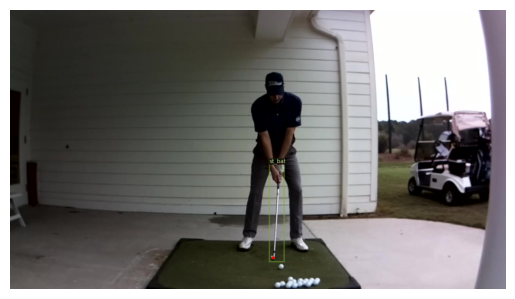

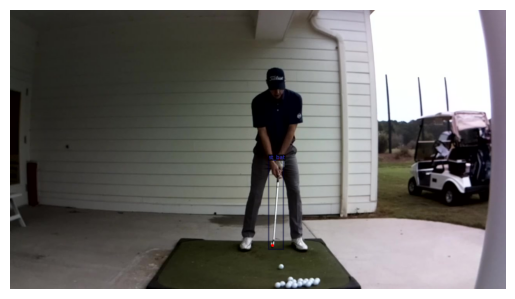

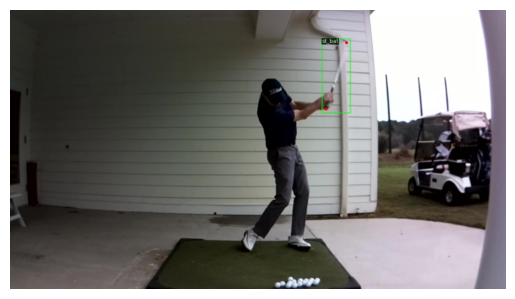

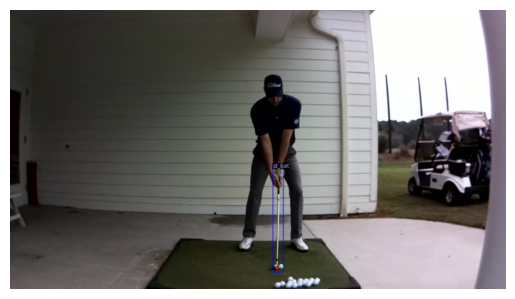

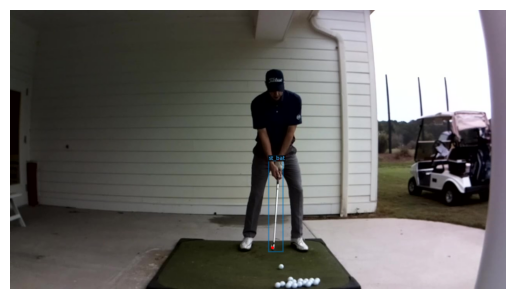

In [8]:
import os
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get(f"{club}_train")
hands_metadata = MetadataCatalog.get(f"{club}_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off')

for d in random.sample(dataset_dicts, 5):
    print("D:", d)
    print("Showing " + d['file_name'])
    
    if not os.path.exists(d["file_name"]):
        print(f"Error: File not found: {d['file_name']}")
        continue
    
    img = cv2.imread(d["file_name"])
    if img is None:
        print(f"Error: Failed to read image file: {d['file_name']}")
        continue
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=1)   
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


## Creating Custom Trainer with Data Augmentation

In [9]:
from detectron2.engine import DefaultTrainer
from typing import List, Optional, Union


class Trainer(DefaultTrainer):
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        is_train = True
        augs = utils.build_augmentation(cfg, is_train)
        augs.append(T.RandomBrightness(intensity_min=0.75, intensity_max=1.25))
        augs.append(T.RandomContrast(intensity_min=0.76, intensity_max=1.25))
        augs.append(T.RandomSaturation(intensity_min=0.75, intensity_max=1.25))
        if cfg.INPUT.CROP.ENABLED and is_train:
            augs.insert(0, T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE))
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True, augmentations= augs))

Configure the model paramaters.

In [10]:

train_dataset_dicts = DatasetCatalog.get(f"{club}_train")

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{club}_train",)
cfg.DATASETS.TEST = (f"{club}_test",)  

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.SOLVER.BASE_LR = 0.0008  # pick a good LR
cfg.SOLVER.MAX_ITER = len(train_dataset_dicts) // BATCH_SIZE * EPOCHS   # MAX_ITER = total images / batch size * epochs
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # bat
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 2
cfg.TEST.KEYPOINT_OKS_SIGMAS = tuple(np.ones(2, dtype=float).tolist())

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

[03/31 11:27:31 d2.data.datasets.coco]: Loaded 188 images in COCO format from /content/drive/MyDrive/golftrain/data/train.json


### Train the model...

In [13]:
trainer = Trainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
model_path = cfg.OUTPUT_DIR + "/model_final.pth"
file_size = int(os.path.getsize(model_path) / (1024 * 1024))
print(f"Model trained as <{model_path}> = {file_size} MB.")
os.rename(model_path, cfg.OUTPUT_DIR +  f"/{club}_model.pth")
print(f"Done! Model file renamed to <{club}_model.pth>")

Model trained as <./output/model_final.pth> = 594.9066076278687 MB.
Done! Model file renamed to <golf_model.pth>


### Load the newly built model and run it on a test image...

In [16]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, f"{club}_model.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 # set a custom testing threshold


def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');

predictor = DefaultPredictor(cfg)
im = cv2.imread(f"{datafolder}110_53292190-DE8D-EB91-521C-FF44D4E33C02_0010.jpg")
outputs = predictor(im)
print(outputs)
o = outputs["instances"]
print("--------------------------------------------------------")


[03/31 11:59:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/golf_model.pth ...
{'instances': Instances(num_instances=2, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[655.4764, 366.6914, 707.9787, 596.9921],
        [602.9298, 370.2043, 719.3070, 622.7256]], device='cuda:0')), scores: tensor([0.9993, 0.5473], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0'), pred_keypoints: tensor([[[7.0082e+02, 3.7965e+02, 2.6356e-01],
         [6.6454e+02, 5.9651e+02, 1.2643e-01]],

        [[7.0166e+02, 3.8120e+02, 4.0141e-01],
         [6.6541e+02, 5.9451e+02, 2.0576e-01]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[ -7.3861,  -8.3160, -10.1758,  ...,  -1.7758,  -1.8904,  -1.9476],
          [ -8.2160,  -9.1458, -11.0055,  ...,  -0.5234,  -1.1216,  -1.4207],
          [ -9.8757, -10.8054, -12.6648,  ...,   1.9814,   0.4158,  -0.3670],
          ...,
          [ -6.2337,  -5.7923,  -4.9094,  ...,  -8.1987,  -7.7

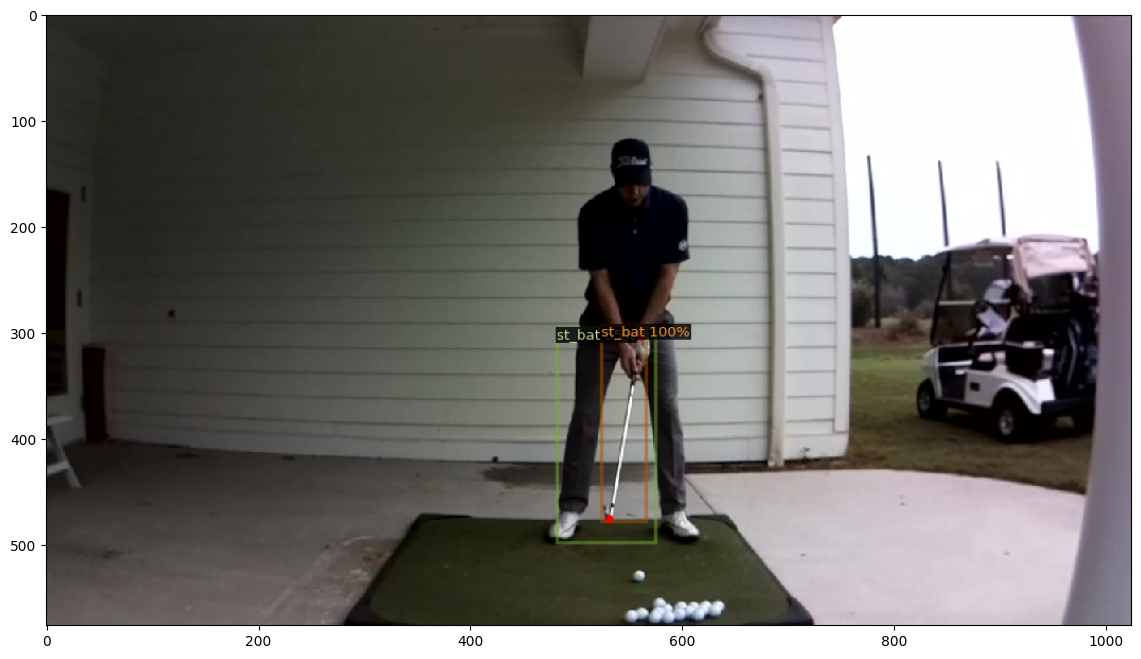

In [17]:
v = Visualizer(im[:, :, ::-1], metadata=hands_metadata, scale=0.8)    # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

2
keypoint: [[7.0081927e+02 3.7964578e+02 2.6355696e-01]
 [6.6454498e+02 5.9651227e+02 1.2642784e-01]]
keypoint: [[7.0165967e+02 3.8120428e+02 4.0140840e-01]
 [6.6541101e+02 5.9450824e+02 2.0576194e-01]]


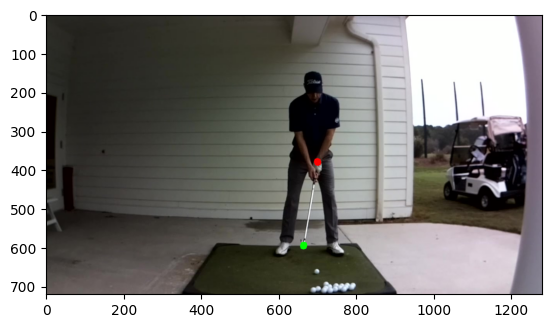

In [18]:
results = []
colors = [(0, 0, 255), (0, 255, 0)]
instances = outputs["instances"].to("cpu")
print(len(instances))
if len(instances) > 0:
    result_dict = {'filename': 'filename'}
    for score, kp,  in zip(instances.scores.numpy(), instances.pred_keypoints.numpy()):
        print(f"keypoint: {kp}")
        result_dict.update({'xNob': kp[0][0],'yNob': kp[0][1],'xTip': kp[1][0],'yTip': kp[1][1]})
        im = cv2.circle(im, (int(kp[0][0]),int(kp[0][1])), radius=1, color=colors[0], thickness=15)
        im = cv2.circle(im, (int(kp[1][0]),int(kp[1][1])), radius=1, color=colors[1], thickness=15)
        
        result_dict['confidenceScore'] = score
        results.append(result_dict)
            
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()

In [19]:
results

[{'filename': 'filename',
  'xNob': 701.65967,
  'yNob': 381.20428,
  'xTip': 665.411,
  'yTip': 594.50824,
  'confidenceScore': 0.54730546},
 {'filename': 'filename',
  'xNob': 701.65967,
  'yNob': 381.20428,
  'xTip': 665.411,
  'yTip': 594.50824,
  'confidenceScore': 0.54730546}]

In [20]:
outputs["instances"].pred_keypoints.cpu().numpy()[0]

array([[7.0081927e+02, 3.7964578e+02, 2.6355696e-01],
       [6.6454498e+02, 5.9651227e+02, 1.2642784e-01]], dtype=float32)

[03/31 12:00:50 d2.data.datasets.coco]: Loaded 21 images in COCO format from /content/drive/MyDrive/golftrain/data/test.json
{'instances': Instances(num_instances=1, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[669.5650, 384.9935, 706.6366, 656.3381]], device='cuda:0')), scores: tensor([0.9997], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[6.9761e+02, 3.9986e+02, 2.2968e-01],
         [6.7955e+02, 6.5586e+02, 1.6418e-01]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[ -6.0315,  -6.7888,  -8.3035,  ...,  -7.3219,  -6.5425,  -6.1528],
          [ -6.6938,  -7.3724,  -8.7295,  ...,  -7.2462,  -6.8288,  -6.6201],
          [ -8.0185,  -8.5395,  -9.5815,  ...,  -7.0946,  -7.4012,  -7.5545],
          ...,
          [ -8.0038,  -8.1854,  -8.5487,  ..., -10.2021,  -9.7857,  -9.5775],
          [ -6.5682,  -6.9138,  -7.6051,  ...,  -9.7361,  -9.0201,  -8.6621],
          [ -5.8504,  -6.2780,  -7.1333,  ...,  -9.5030,

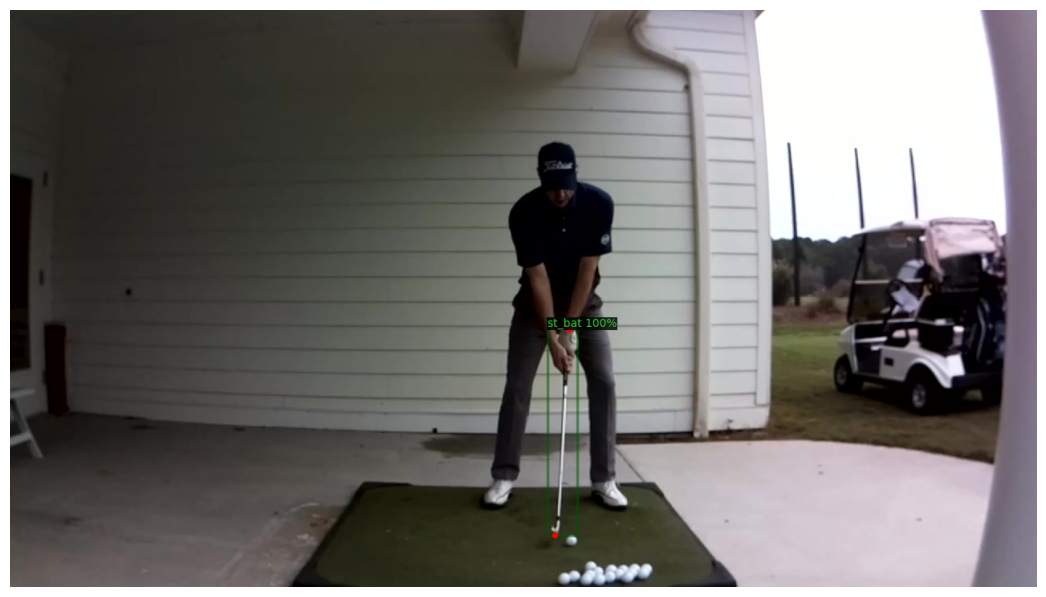

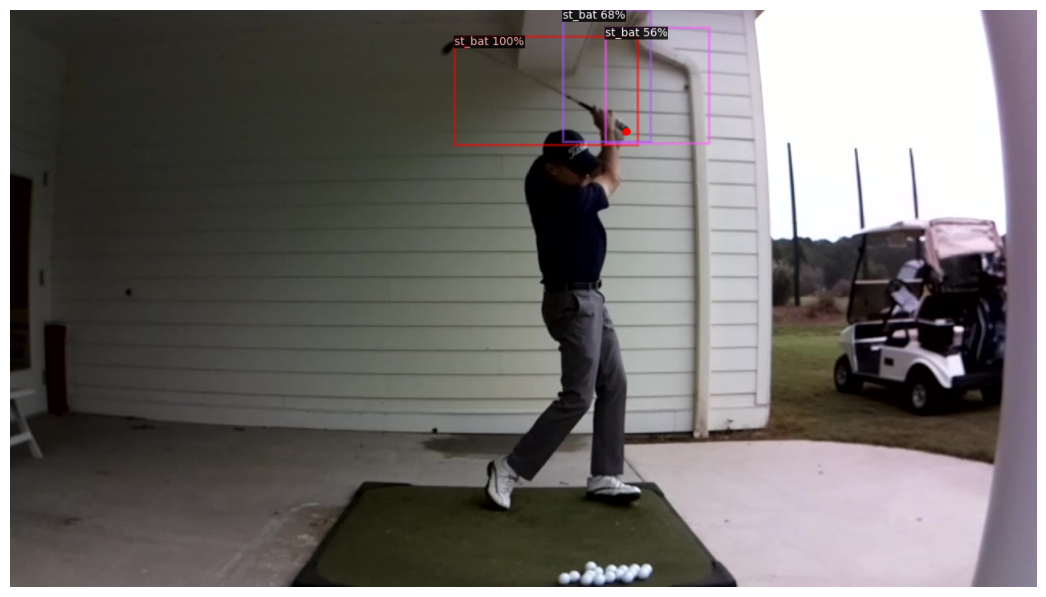

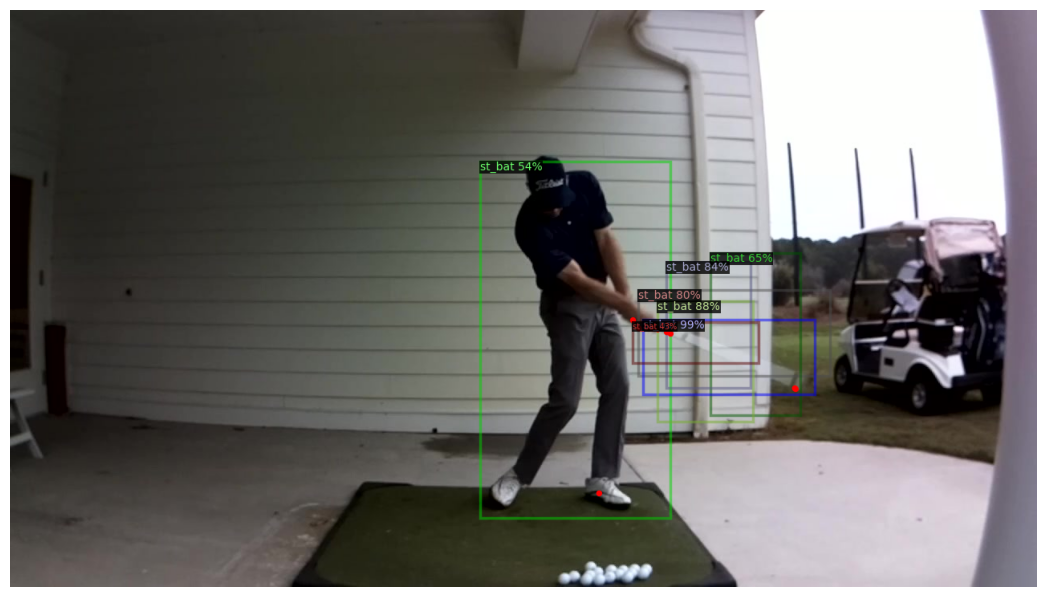

In [21]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get(f"{club}_test")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=hands_metadata, 
                   scale=1   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(f"{club}_test", output_dir="./output", kpt_oks_sigmas = tuple(np.ones((2,1), dtype=float).tolist()))
val_loader = build_detection_test_loader(cfg, f"{club}_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/31 12:01:12 d2.data.datasets.coco]: Loaded 21 images in COCO format from /content/drive/MyDrive/golftrain/data/test.json
[03/31 12:01:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/31 12:01:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/31 12:01:12 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[03/31 12:01:12 d2.data.common]: Serialized dataset takes 0.01 MiB
[03/31 12:01:12 d2.evaluation.evaluator]: Start inference on 21 batches


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[03/31 12:01:15 d2.evaluation.evaluator]: Inference done 11/21. Dataloading: 0.0031 s/iter. Inference: 0.1642 s/iter. Eval: 0.0005 s/iter. Total: 0.1677 s/iter. ETA=0:00:01
[03/31 12:01:17 d2.evaluation.evaluator]: Total inference time: 0:00:02.814043 (0.175878 s / iter per device, on 1 devices)
[03/31 12:01:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.164879 s / iter per device, on 1 devices)
[03/31 12:01:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/31 12:01:17 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/31 12:01:17 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[03/31 12:01:17 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[03/31 12:01:17 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[03/31 12:01:17 d2.evaluation.